In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

# Define the Generator and Discriminator Newtorks

In [2]:
# All networks should inherit `nn.Module`
class Generator(nn.Module):
    """
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64
    
    input is bacth_size x n_ch x width x height.
    In this case, (batch_size, 100, 1, 1)
    """
    
    # Note on convolutional transpose operations:
    # Input: (batch, chs_in, h_in, w_in)
    # Output: (batch, chs_out, h_out, w_out)
    # h_out = (h_in-1) * stride - 2 * padding + kernel
    
    # Anything with optimizable parameters needs to be
    # setup within the init method
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=256,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=32,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    # All modules must override `forward`
    def forward(self, x):
        x = self.main(x)
        return x

In [3]:
# Confirm the generator creates an image when given noise
# Map from (batch, 100, 1, 1) to (batch, 1, 32, 32)
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [4]:
class Discriminator(nn.Module):
    """
    Takes in a 32x32 image and produces a decision
    about if that image is genuine or generated.
    
    Input is (bacth_size x n_ch x width x height)
    In this case (100, 1, 64, 64)
    """
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # input is 1ch x 64w x 64h
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=256,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [5]:
# Confirm the discriminator produces a ruling given an image
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

# Prepare Data
### Note: All images are of size 64 x 86

In [6]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='/home/seif.younis/Deep Learning and Medical Imaging/images_64',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), # Make smallest dimension 32
            torchvision.transforms.CenterCrop(64), # Cut to square image
            torchvision.transforms.Grayscale(), # Convert to grayscale
            torchvision.transforms.ToTensor(), # Transform from PIL image to Tensor
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [7]:
# Utility methods for displaying data during training
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.figure(figsize = (20,2))
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

torch.Size([8, 1, 64, 64])


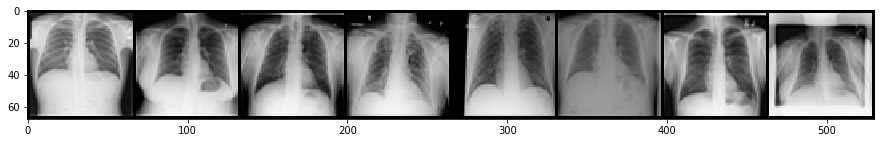

In [8]:
# Test on one a handful of images
# ...<rimshot.wav> :P
for data, _ in build_data_loader(8):
    test_images = data
    break
    
print(test_images.shape)
show_images(test_images)

# Perform Training

In [9]:
# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

In [10]:
# Specify training details
n_epochs = 100
batch_size = 100

In [11]:
# Move everything to the GPU for training
gpu = torch.device(0)

G = nn.DataParallel(G, [0,1,2])
G = G.to(gpu)

D = nn.DataParallel(D, [0,1,2])
D = D.to(gpu)

In [12]:
# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/100
Example images:


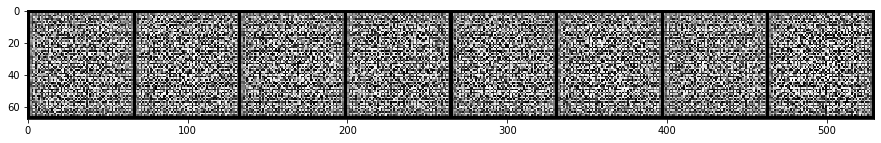

Epoch: 0	Batch: 100/101
Loss G: 6.492521286010742
Loss D: 0.007639097515493631
Epoch: 1/100
Example images:


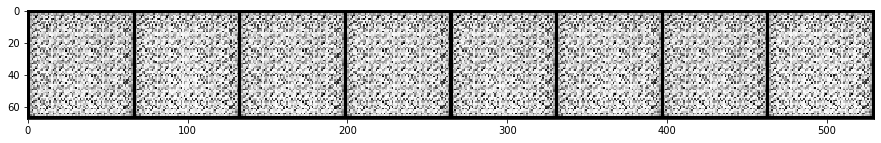

Epoch: 1	Batch: 100/101
Loss G: 7.329936981201172
Loss D: 0.22907888889312744
Epoch: 2/100
Example images:


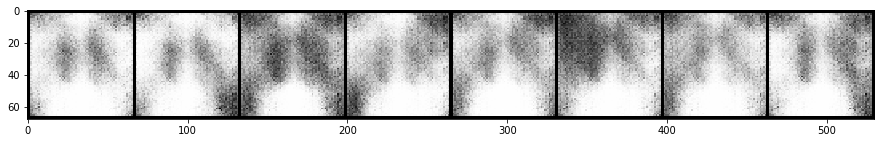

Epoch: 2	Batch: 100/101
Loss G: 5.351540565490723
Loss D: 0.5522180795669556
Epoch: 3/100
Example images:


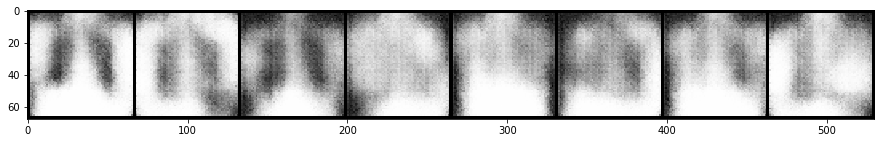

Epoch: 3	Batch: 100/101
Loss G: 12.931716918945312
Loss D: 3.2287912368774414
Epoch: 4/100
Example images:


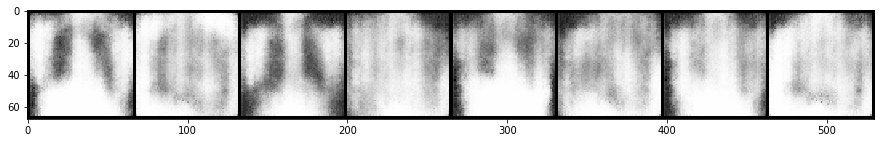

Epoch: 4	Batch: 100/101
Loss G: 10.517998695373535
Loss D: 0.5732812881469727
Epoch: 5/100
Example images:


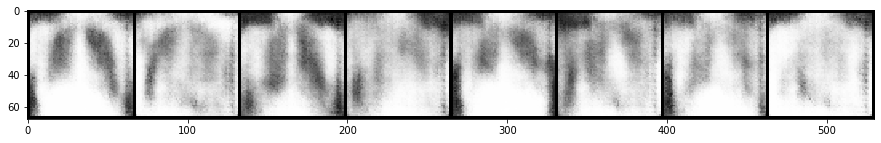

Epoch: 5	Batch: 100/101
Loss G: 3.271958589553833
Loss D: 0.29574865102767944
Epoch: 6/100
Example images:


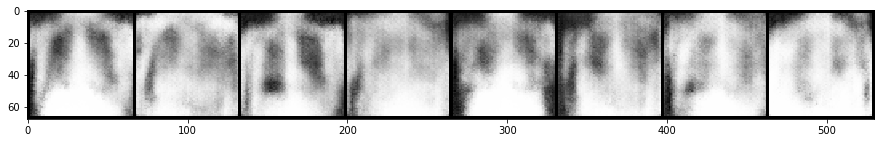

Epoch: 6	Batch: 100/101
Loss G: 5.782942771911621
Loss D: 0.3838663399219513
Epoch: 7/100
Example images:


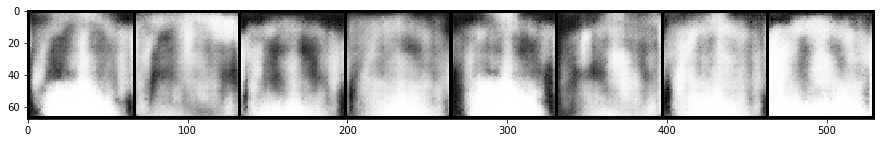

Epoch: 7	Batch: 100/101
Loss G: 3.9378106594085693
Loss D: 0.1319093257188797
Epoch: 8/100
Example images:


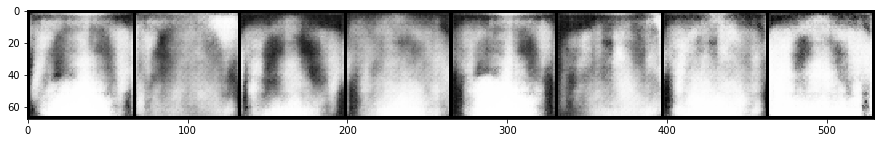

Epoch: 8	Batch: 100/101
Loss G: 4.997270584106445
Loss D: 0.23914122581481934
Epoch: 9/100
Example images:


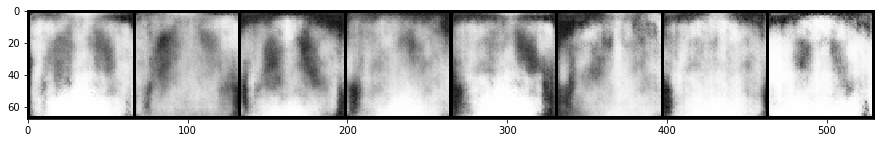

Epoch: 9	Batch: 100/101
Loss G: 5.292813301086426
Loss D: 0.0522097572684288
Epoch: 10/100
Example images:


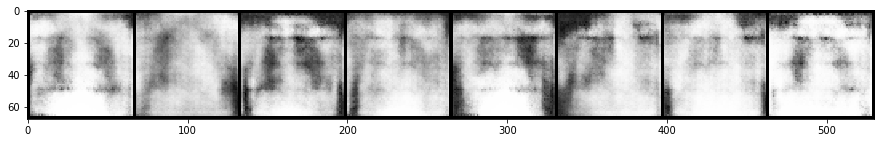

Epoch: 10	Batch: 100/101
Loss G: 5.598361492156982
Loss D: 0.05482567474246025
Epoch: 11/100
Example images:


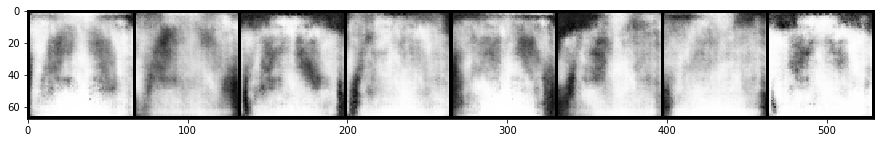

Epoch: 11	Batch: 100/101
Loss G: 7.24955940246582
Loss D: 0.13509789109230042
Epoch: 12/100
Example images:


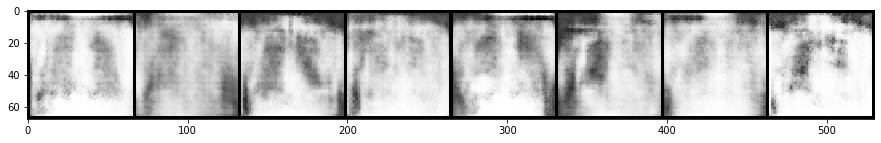

Epoch: 12	Batch: 100/101
Loss G: 6.452411651611328
Loss D: 0.12777253985404968
Epoch: 13/100
Example images:


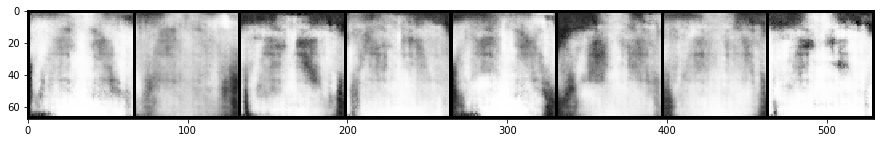

Epoch: 13	Batch: 100/101
Loss G: 6.8354597091674805
Loss D: 0.10373493283987045
Epoch: 14/100
Example images:


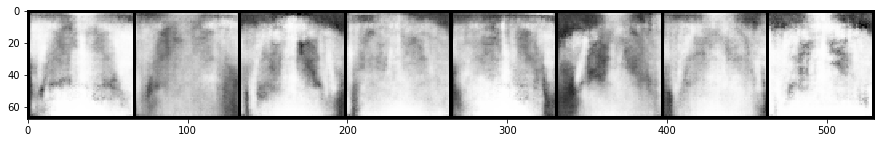

Epoch: 14	Batch: 100/101
Loss G: 4.231967926025391
Loss D: 0.061339206993579865
Epoch: 15/100
Example images:


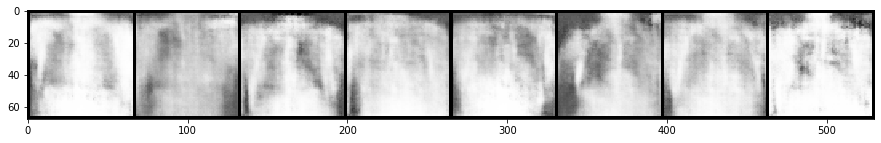

Epoch: 15	Batch: 100/101
Loss G: 6.239083766937256
Loss D: 0.07683368027210236
Epoch: 16/100
Example images:


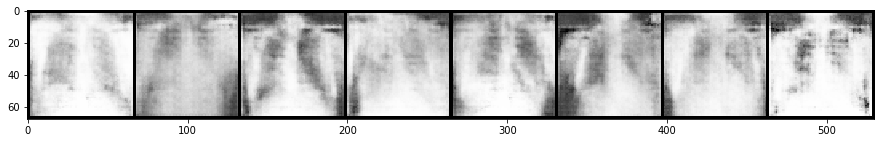

Epoch: 16	Batch: 100/101
Loss G: 5.722744464874268
Loss D: 0.012041772715747356
Epoch: 17/100
Example images:


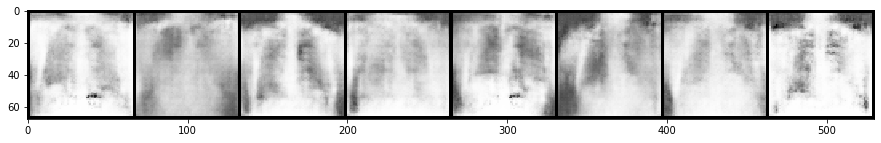

Epoch: 17	Batch: 100/101
Loss G: 14.06551742553711
Loss D: 0.3372742533683777
Epoch: 18/100
Example images:


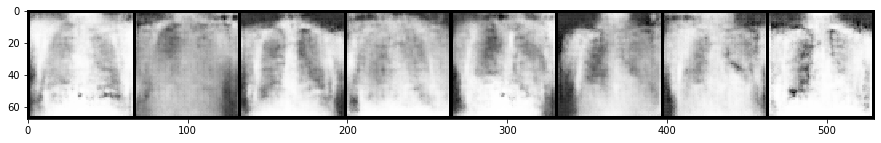

Epoch: 18	Batch: 100/101
Loss G: 6.114531517028809
Loss D: 0.015289605595171452
Epoch: 19/100
Example images:


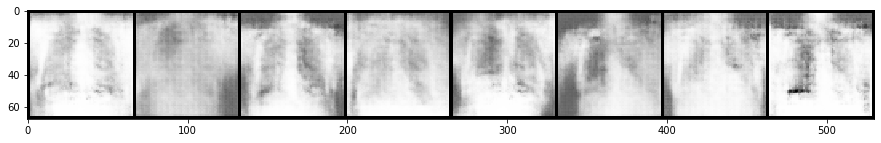

Epoch: 19	Batch: 100/101
Loss G: 5.608448028564453
Loss D: 0.019918132573366165
Epoch: 20/100
Example images:


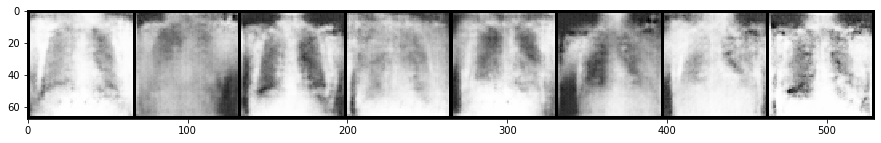

Epoch: 20	Batch: 100/101
Loss G: 7.329656600952148
Loss D: 0.03134020417928696
Epoch: 21/100
Example images:


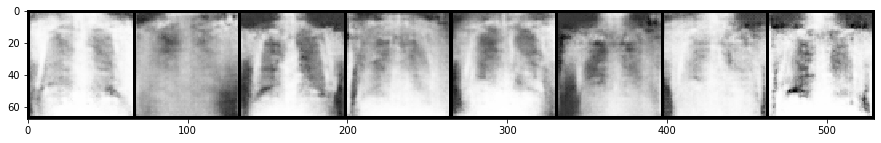

Epoch: 21	Batch: 100/101
Loss G: 5.290178298950195
Loss D: 0.016738206148147583
Epoch: 22/100
Example images:


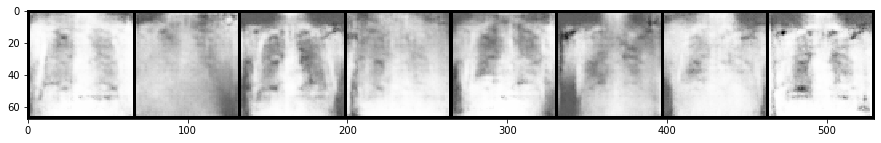

Epoch: 22	Batch: 100/101
Loss G: 6.173783302307129
Loss D: 0.01730051450431347
Epoch: 23/100
Example images:


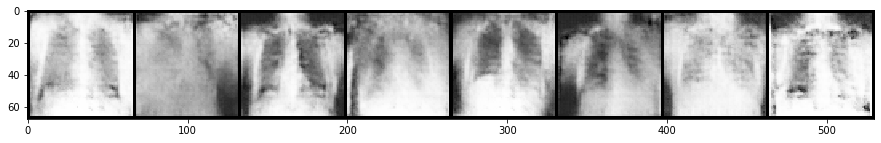

Epoch: 23	Batch: 100/101
Loss G: 5.339931011199951
Loss D: 0.018727147951722145
Epoch: 24/100
Example images:


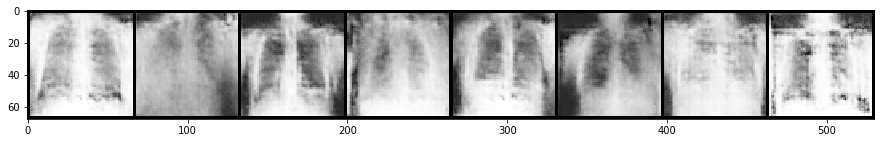

Epoch: 24	Batch: 100/101
Loss G: 6.468288421630859
Loss D: 0.013110170140862465
Epoch: 25/100
Example images:


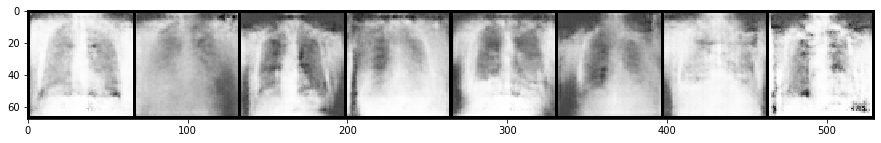

Epoch: 25	Batch: 100/101
Loss G: 6.986142635345459
Loss D: 0.014468025416135788
Epoch: 26/100
Example images:


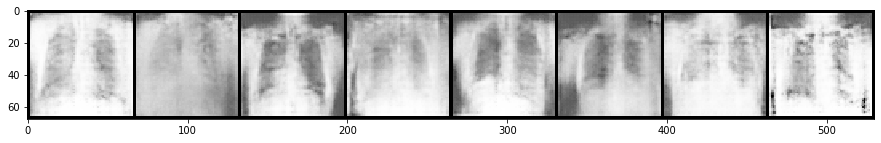

Epoch: 26	Batch: 100/101
Loss G: 14.5358247756958
Loss D: 0.19253474473953247
Epoch: 27/100
Example images:


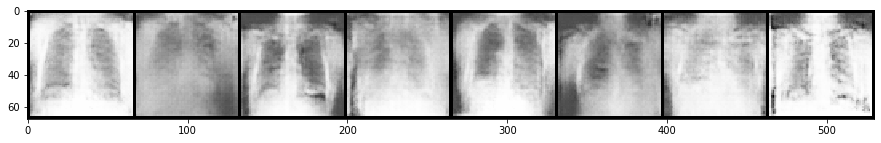

Epoch: 27	Batch: 100/101
Loss G: 5.524644374847412
Loss D: 0.015025900676846504
Epoch: 28/100
Example images:


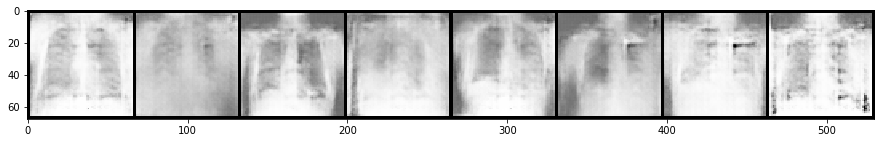

Epoch: 28	Batch: 100/101
Loss G: 10.697803497314453
Loss D: 0.09589633345603943
Epoch: 29/100
Example images:


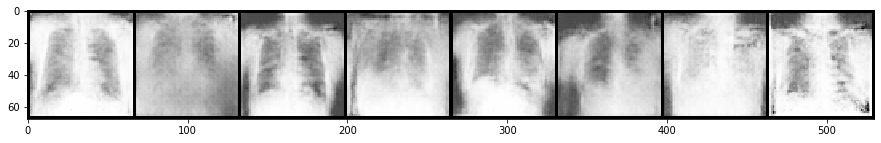

Epoch: 29	Batch: 100/101
Loss G: 6.121205806732178
Loss D: 0.027479354292154312
Epoch: 30/100
Example images:


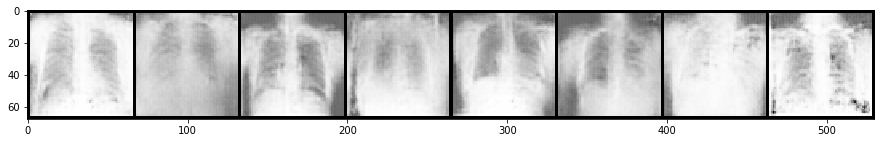

Epoch: 30	Batch: 100/101
Loss G: 14.83402156829834
Loss D: 0.16432151198387146
Epoch: 31/100
Example images:


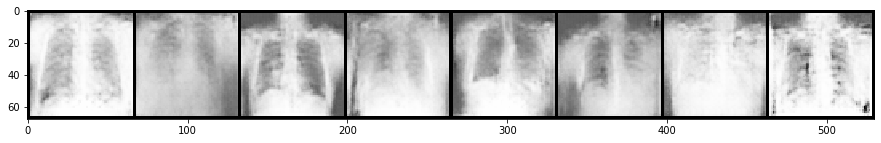

Epoch: 31	Batch: 100/101
Loss G: 7.896368503570557
Loss D: 0.004390371963381767
Epoch: 32/100
Example images:


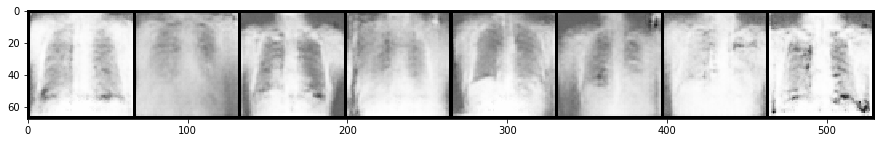

Epoch: 32	Batch: 100/101
Loss G: 6.1067891120910645
Loss D: 0.006540448870509863
Epoch: 33/100
Example images:


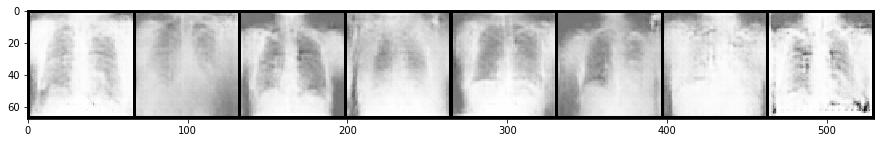

Epoch: 33	Batch: 100/101
Loss G: 6.135253429412842
Loss D: 0.029068300500512123
Epoch: 34/100
Example images:


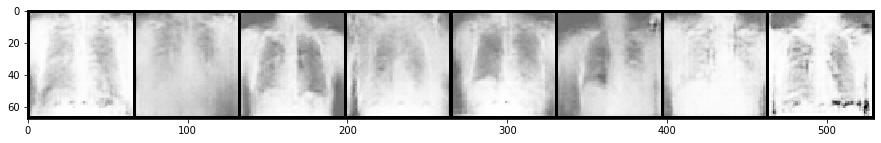

Epoch: 34	Batch: 100/101
Loss G: 6.014257907867432
Loss D: 0.03657102584838867
Epoch: 35/100
Example images:


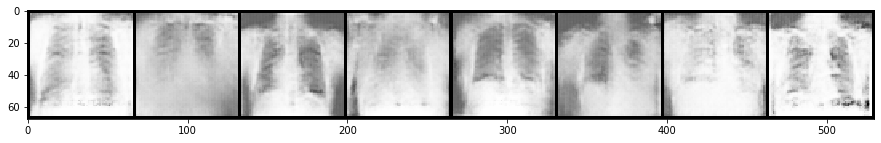

Epoch: 35	Batch: 100/101
Loss G: 8.458035469055176
Loss D: 0.0064653027802705765
Epoch: 36/100
Example images:


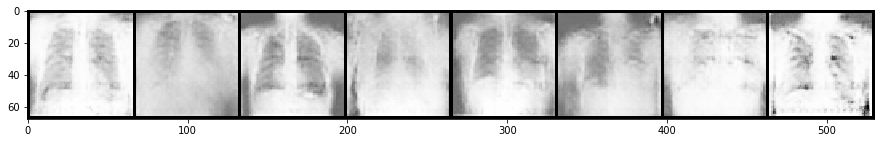

Epoch: 36	Batch: 100/101
Loss G: 11.367681503295898
Loss D: 0.08639485388994217
Epoch: 37/100
Example images:


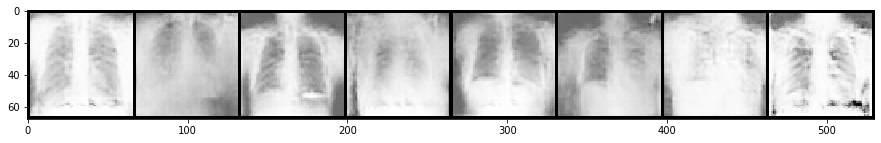

Epoch: 37	Batch: 100/101
Loss G: 6.445518493652344
Loss D: 0.009550221264362335
Epoch: 38/100
Example images:


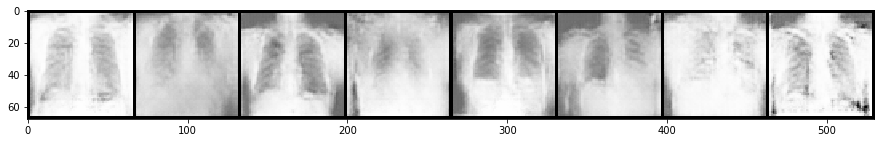

Epoch: 38	Batch: 100/101
Loss G: 7.6800923347473145
Loss D: 0.006648925133049488
Epoch: 39/100
Example images:


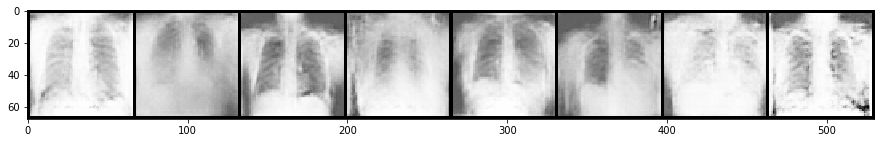

Epoch: 39	Batch: 100/101
Loss G: 7.720334053039551
Loss D: 0.0013072905130684376
Epoch: 40/100
Example images:


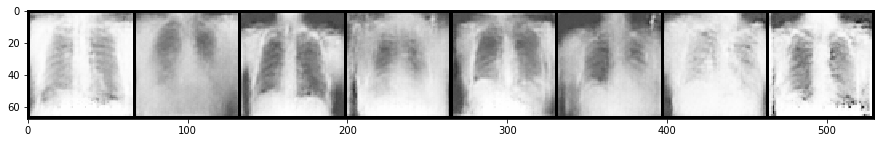

Epoch: 40	Batch: 100/101
Loss G: 6.708800315856934
Loss D: 0.00859279464930296
Epoch: 41/100
Example images:


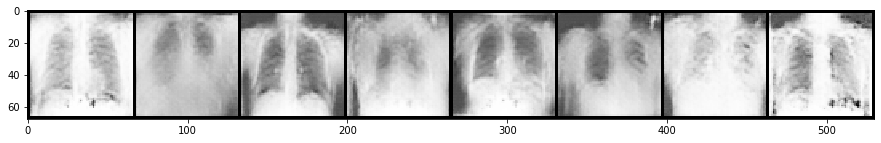

Epoch: 41	Batch: 100/101
Loss G: 8.601500511169434
Loss D: 0.047743216156959534
Epoch: 42/100
Example images:


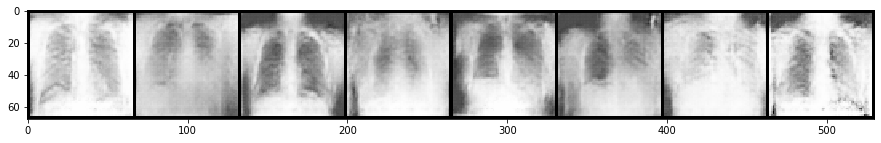

Epoch: 42	Batch: 100/101
Loss G: 10.9859619140625
Loss D: 0.05503474920988083
Epoch: 43/100
Example images:


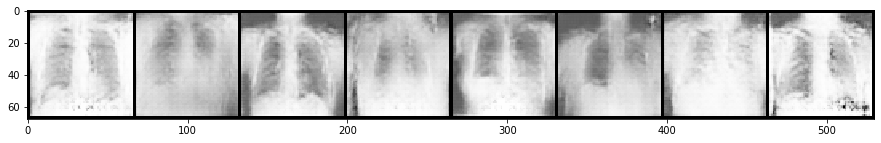

Epoch: 43	Batch: 100/101
Loss G: 10.083602905273438
Loss D: 0.03748400881886482
Epoch: 44/100
Example images:


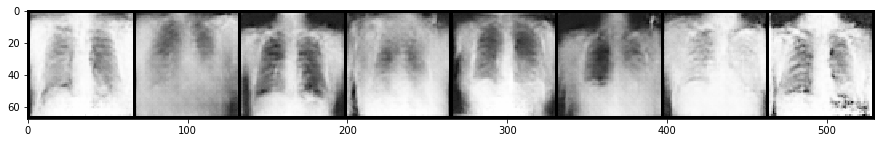

Epoch: 44	Batch: 100/101
Loss G: 8.327007293701172
Loss D: 0.0014033472398295999
Epoch: 45/100
Example images:


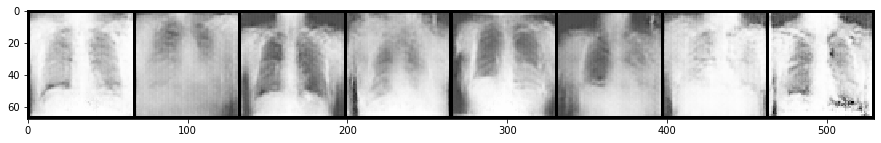

Epoch: 45	Batch: 100/101
Loss G: 11.203790664672852
Loss D: 0.10106247663497925
Epoch: 46/100
Example images:


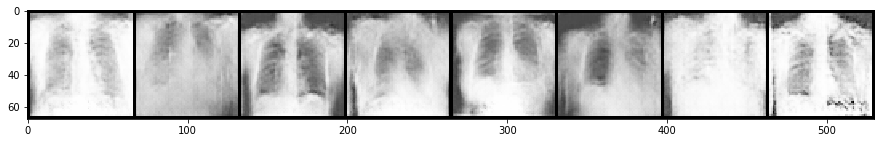

Epoch: 46	Batch: 100/101
Loss G: 10.29709529876709
Loss D: 0.0654262825846672
Epoch: 47/100
Example images:


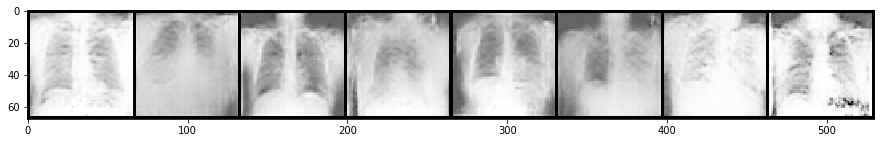

Epoch: 47	Batch: 100/101
Loss G: 6.4615864753723145
Loss D: 0.01575133018195629
Epoch: 48/100
Example images:


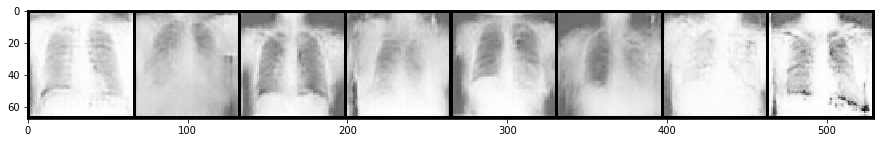

Epoch: 48	Batch: 100/101
Loss G: 10.260199546813965
Loss D: 0.04626612365245819
Epoch: 49/100
Example images:


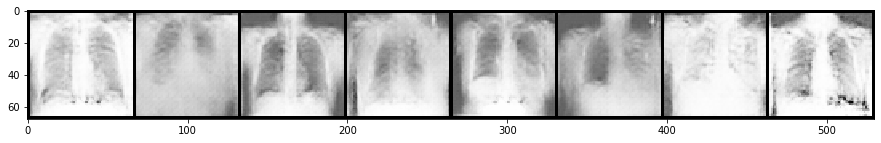

Epoch: 49	Batch: 100/101
Loss G: 12.228509902954102
Loss D: 0.05153173580765724
Epoch: 50/100
Example images:


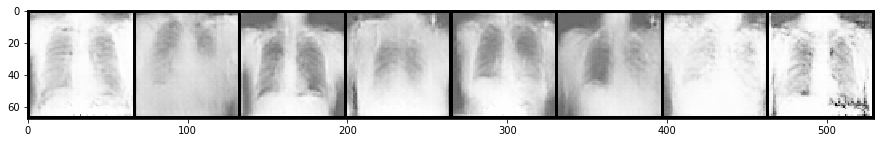

Epoch: 50	Batch: 100/101
Loss G: 6.553982257843018
Loss D: 0.0034730485640466213
Epoch: 51/100
Example images:


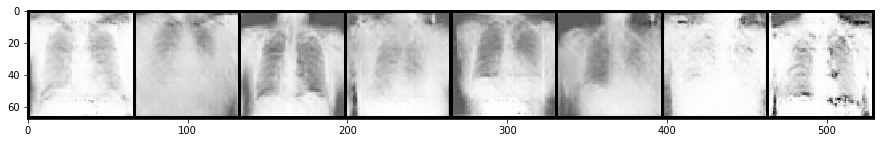

Epoch: 51	Batch: 100/101
Loss G: 8.455263137817383
Loss D: 0.0017921838443726301
Epoch: 52/100
Example images:


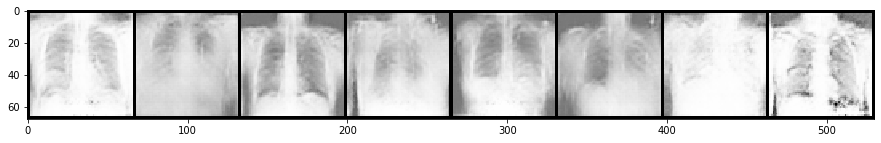

Epoch: 52	Batch: 100/101
Loss G: 10.037518501281738
Loss D: 0.0026385346427559853
Epoch: 53/100
Example images:


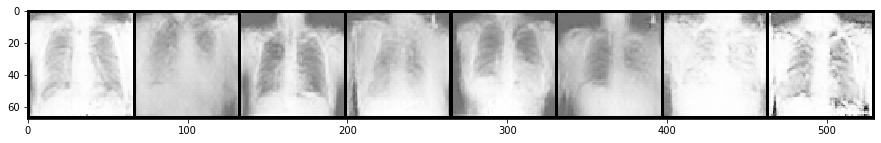

Epoch: 53	Batch: 100/101
Loss G: 24.91191291809082
Loss D: 0.15200121700763702
Epoch: 54/100
Example images:


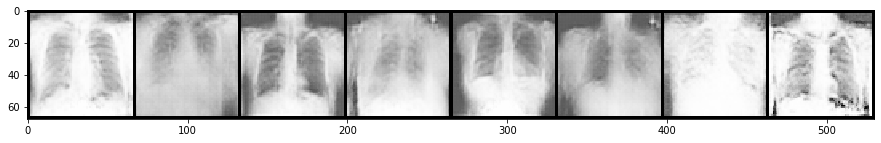

Epoch: 54	Batch: 100/101
Loss G: 8.410917282104492
Loss D: 0.12514503300189972
Epoch: 55/100
Example images:


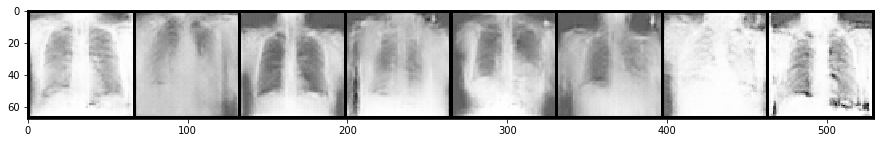

Epoch: 55	Batch: 100/101
Loss G: 6.656167030334473
Loss D: 0.004193078260868788
Epoch: 56/100
Example images:


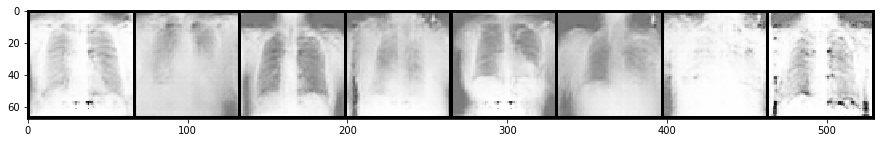

Epoch: 56	Batch: 100/101
Loss G: 7.8106794357299805
Loss D: 0.0011738837929442525
Epoch: 57/100
Example images:


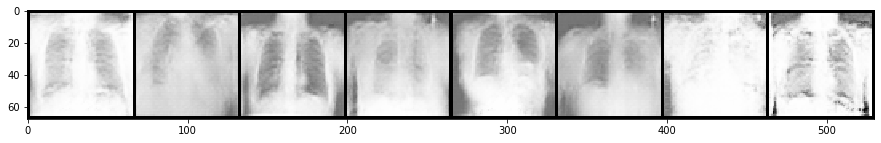

Epoch: 57	Batch: 100/101
Loss G: 8.587825775146484
Loss D: 0.0004381252801977098
Epoch: 58/100
Example images:


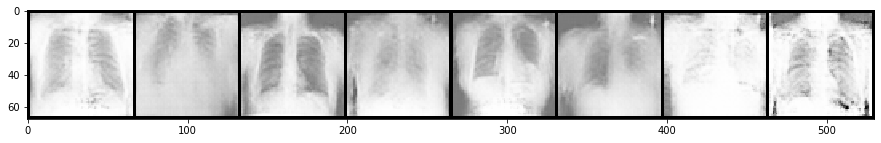

Epoch: 58	Batch: 100/101
Loss G: 9.723020553588867
Loss D: 0.00012958755542058498
Epoch: 59/100
Example images:


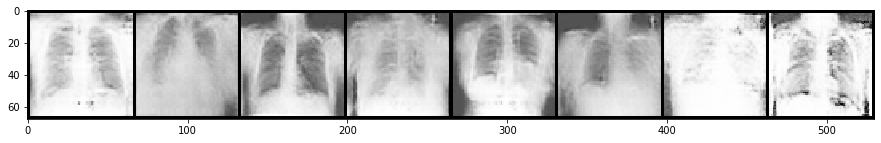

Epoch: 59	Batch: 100/101
Loss G: 11.527697563171387
Loss D: 0.03734860569238663
Epoch: 60/100
Example images:


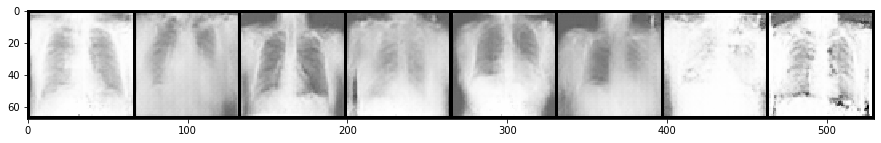

Epoch: 60	Batch: 100/101
Loss G: 7.847714424133301
Loss D: 0.005980587098747492
Epoch: 61/100
Example images:


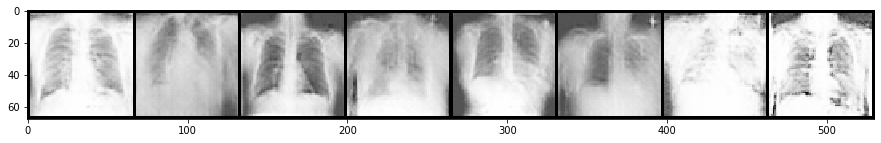

Epoch: 61	Batch: 100/101
Loss G: 12.612106323242188
Loss D: 0.04225444421172142
Epoch: 62/100
Example images:


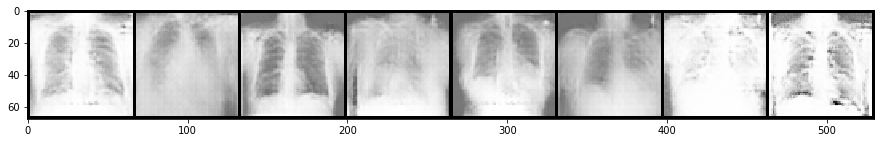

Epoch: 62	Batch: 100/101
Loss G: 9.875494956970215
Loss D: 0.0005148211494088173
Epoch: 63/100
Example images:


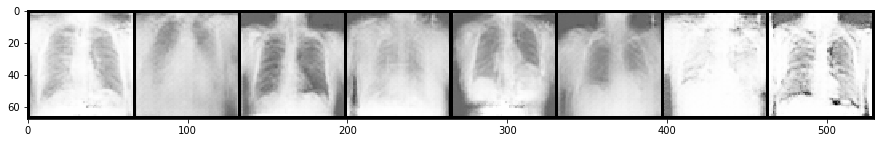

Epoch: 63	Batch: 100/101
Loss G: 10.239179611206055
Loss D: 0.03689458593726158
Epoch: 64/100
Example images:


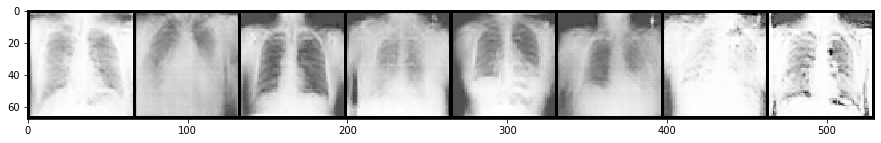

Epoch: 64	Batch: 100/101
Loss G: 17.64714241027832
Loss D: 0.076725073158741
Epoch: 65/100
Example images:


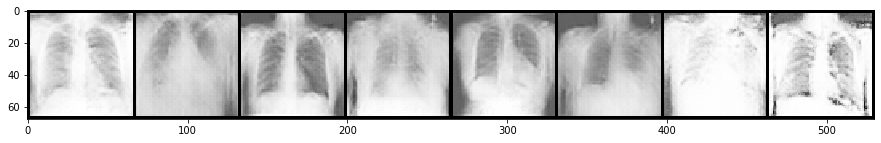

Epoch: 65	Batch: 100/101
Loss G: 7.867343902587891
Loss D: 0.008598375134170055
Epoch: 66/100
Example images:


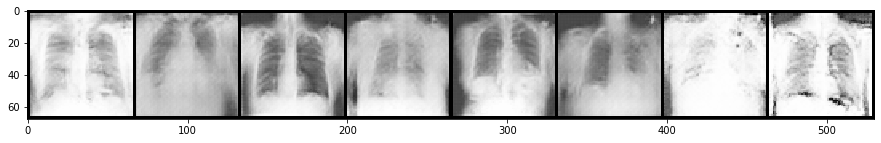

Epoch: 66	Batch: 100/101
Loss G: 8.1281156539917
Loss D: 0.02599440887570381
Epoch: 67/100
Example images:


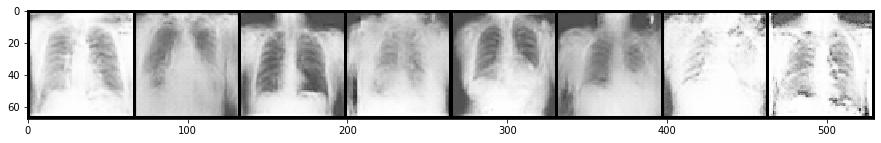

Epoch: 67	Batch: 100/101
Loss G: 14.742802619934082
Loss D: 0.059968460351228714
Epoch: 68/100
Example images:


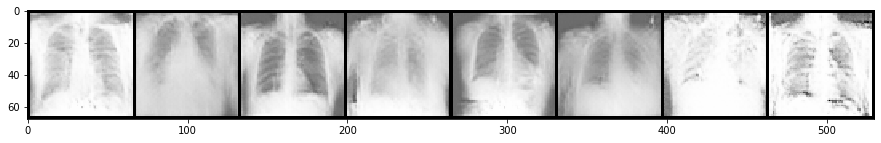

Epoch: 68	Batch: 100/101
Loss G: 7.541082859039307
Loss D: 0.005764540284872055
Epoch: 69/100
Example images:


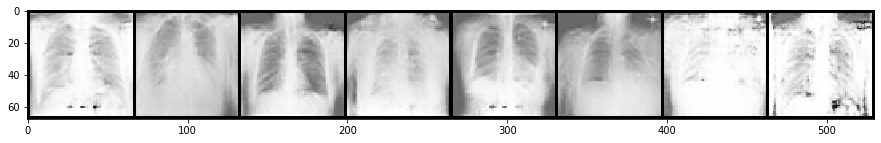

Epoch: 69	Batch: 100/101
Loss G: 8.989883422851562
Loss D: 0.00015939043078105897
Epoch: 70/100
Example images:


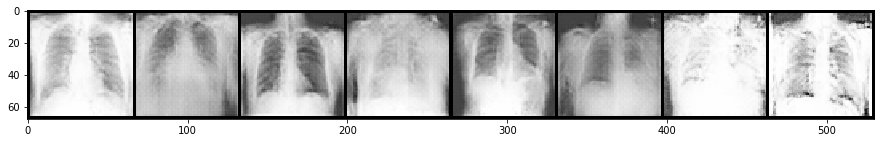

Epoch: 70	Batch: 100/101
Loss G: 9.21617317199707
Loss D: 0.01628902181982994
Epoch: 71/100
Example images:


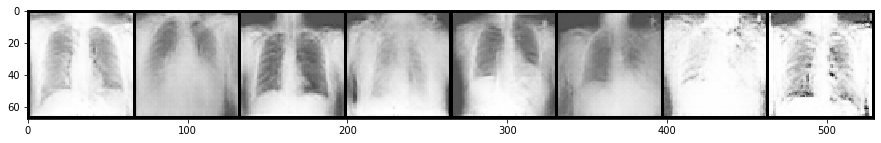

Epoch: 71	Batch: 100/101
Loss G: 7.695528507232666
Loss D: 0.007437519263476133
Epoch: 72/100
Example images:


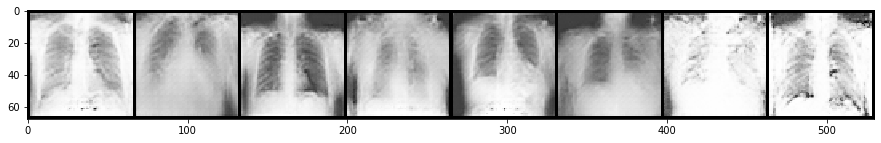

Epoch: 72	Batch: 100/101
Loss G: 8.020689964294434
Loss D: 0.023153183981776237
Epoch: 73/100
Example images:


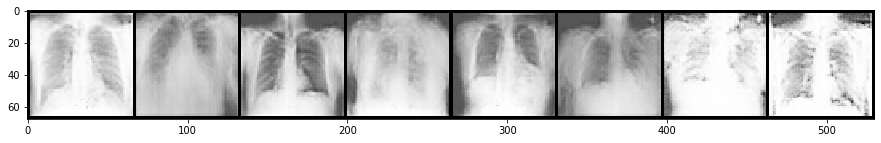

Epoch: 73	Batch: 100/101
Loss G: 9.344305992126465
Loss D: 0.001035500317811966
Epoch: 74/100
Example images:


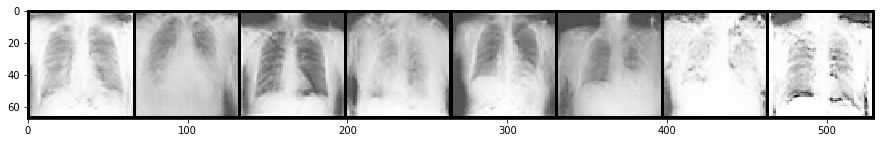

Epoch: 74	Batch: 100/101
Loss G: 6.991917610168457
Loss D: 0.01047863345593214
Epoch: 75/100
Example images:


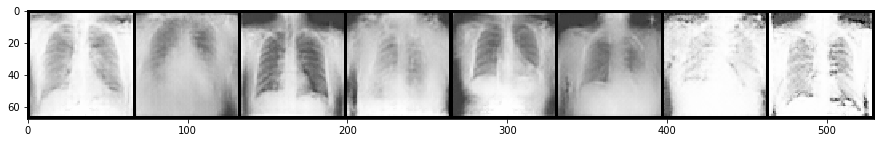

Epoch: 75	Batch: 100/101
Loss G: 8.197245597839355
Loss D: 0.000642348371911794
Epoch: 76/100
Example images:


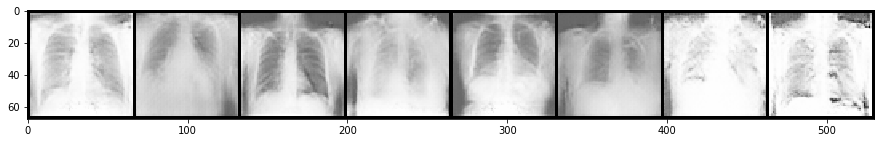

Epoch: 76	Batch: 100/101
Loss G: 7.130982398986816
Loss D: 0.0009257042547687888
Epoch: 77/100
Example images:


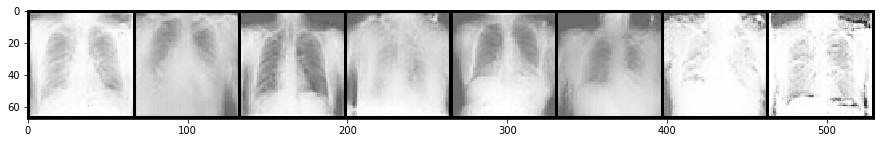

Epoch: 77	Batch: 100/101
Loss G: 9.219071388244629
Loss D: 0.3939925730228424
Epoch: 78/100
Example images:


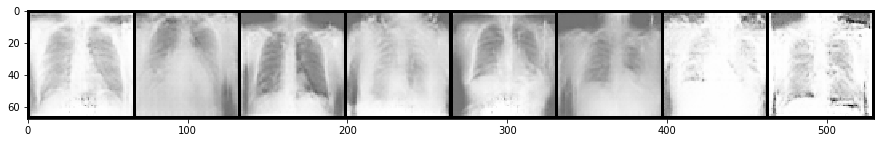

Epoch: 78	Batch: 100/101
Loss G: 6.562417507171631
Loss D: 0.007446287199854851
Epoch: 79/100
Example images:


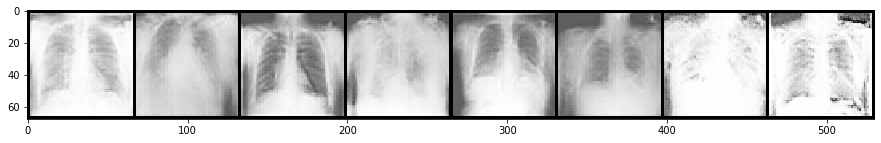

Epoch: 79	Batch: 100/101
Loss G: 41.63119888305664
Loss D: 0.4355485439300537
Epoch: 80/100
Example images:


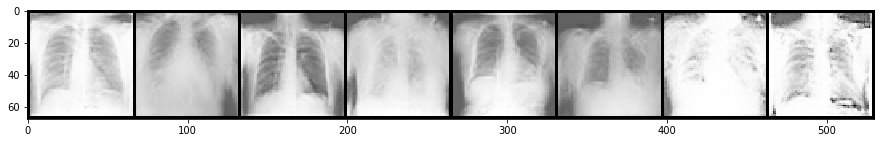

Epoch: 80	Batch: 100/101
Loss G: 8.46949291229248
Loss D: 0.01944289356470108
Epoch: 81/100
Example images:


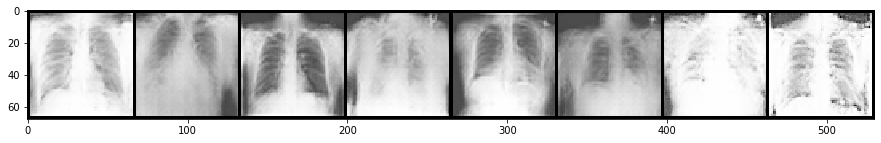

Epoch: 81	Batch: 100/101
Loss G: 7.450907230377197
Loss D: 0.012233213521540165
Epoch: 82/100
Example images:


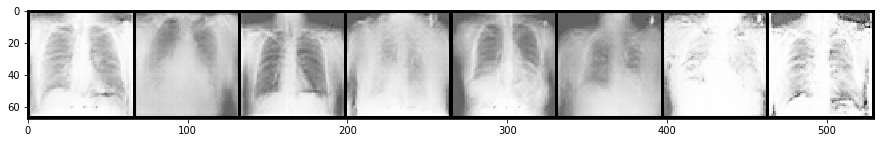

Epoch: 82	Batch: 100/101
Loss G: 6.467957496643066
Loss D: 0.0018499308498576283
Epoch: 83/100
Example images:


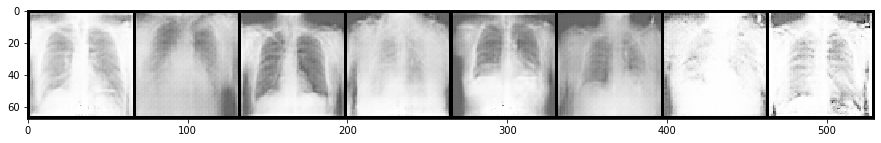

Epoch: 83	Batch: 100/101
Loss G: 30.46257781982422
Loss D: 0.14631521701812744
Epoch: 84/100
Example images:


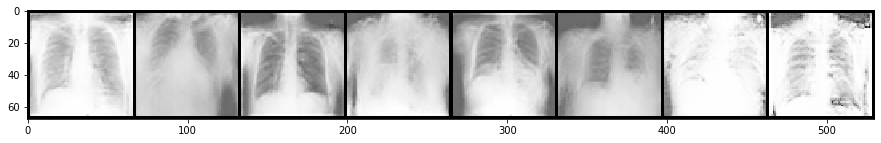

Epoch: 84	Batch: 100/101
Loss G: 14.940619468688965
Loss D: 0.05023547634482384
Epoch: 85/100
Example images:


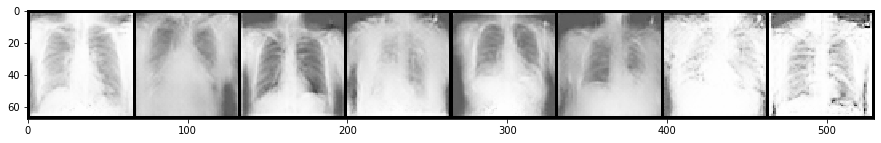

Epoch: 85	Batch: 100/101
Loss G: 7.152699947357178
Loss D: 0.005759821273386478
Epoch: 86/100
Example images:


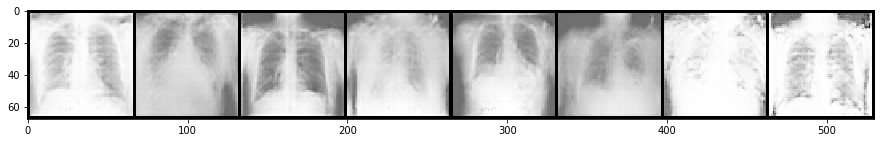

Epoch: 86	Batch: 100/101
Loss G: 7.579913139343262
Loss D: 0.008123097009956837
Epoch: 87/100
Example images:


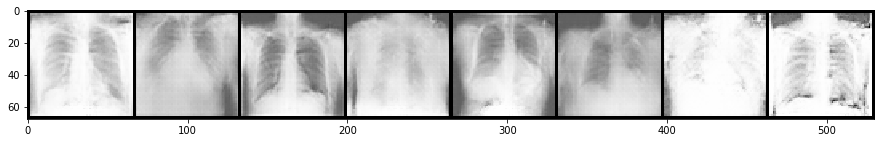

Epoch: 87	Batch: 100/101
Loss G: 10.174088478088379
Loss D: 6.747469160472974e-05
Epoch: 88/100
Example images:


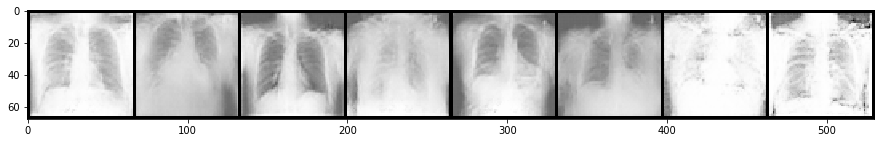

Epoch: 88	Batch: 100/101
Loss G: 9.917964935302734
Loss D: 0.029500562697649002
Epoch: 89/100
Example images:


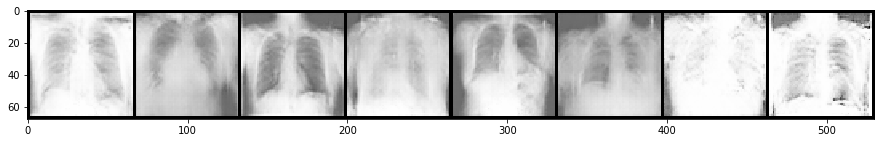

Epoch: 89	Batch: 100/101
Loss G: 6.507810592651367
Loss D: 0.009613612666726112
Epoch: 90/100
Example images:


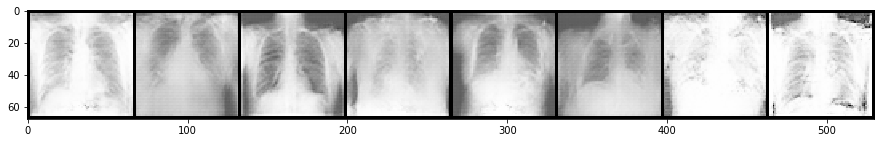

Epoch: 90	Batch: 100/101
Loss G: 47.420440673828125
Loss D: 1.9149073362350464
Epoch: 91/100
Example images:


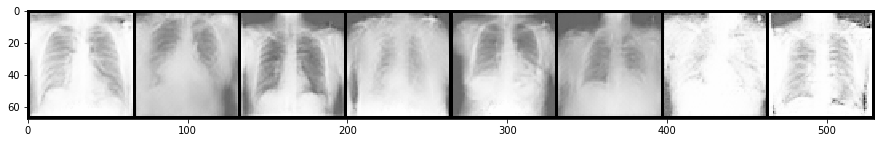

Epoch: 91	Batch: 100/101
Loss G: 6.621325492858887
Loss D: 0.008850176818668842
Epoch: 92/100
Example images:


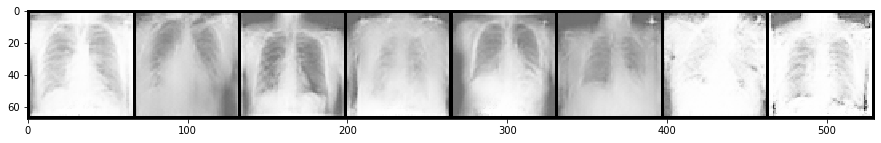

Epoch: 92	Batch: 100/101
Loss G: 11.753141403198242
Loss D: 0.04884212091565132
Epoch: 93/100
Example images:


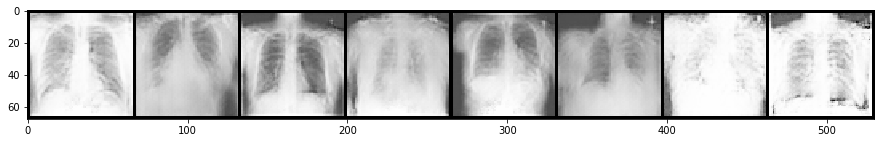

Epoch: 93	Batch: 100/101
Loss G: 9.18057918548584
Loss D: 0.00010198842210229486
Epoch: 94/100
Example images:


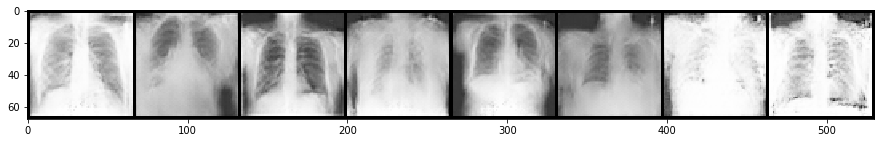

Epoch: 94	Batch: 100/101
Loss G: 13.78557300567627
Loss D: 0.0617900975048542
Epoch: 95/100
Example images:


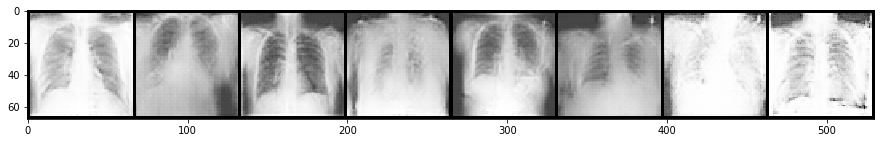

Epoch: 95	Batch: 100/101
Loss G: 7.628929138183594
Loss D: 0.0005992630613036454
Epoch: 96/100
Example images:


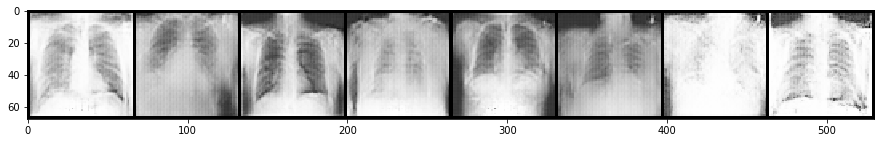

Epoch: 96	Batch: 100/101
Loss G: 7.639710903167725
Loss D: 0.013220792636275291
Epoch: 97/100
Example images:


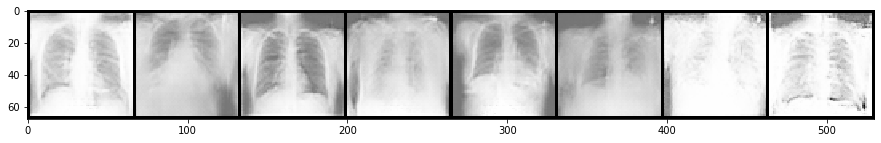

Epoch: 97	Batch: 100/101
Loss G: 7.012548446655273
Loss D: 0.003099144669249654
Epoch: 98/100
Example images:


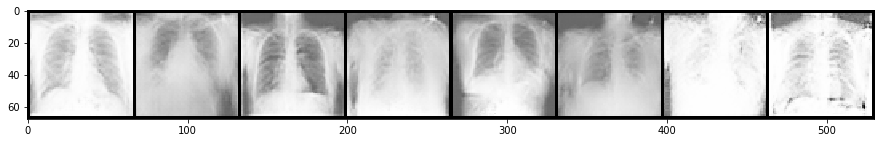

Epoch: 98	Batch: 100/101
Loss G: 7.772089958190918
Loss D: 0.010741951875388622
Epoch: 99/100
Example images:


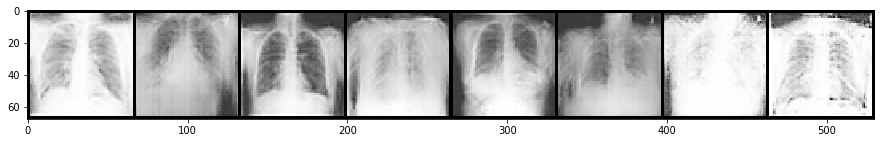

Epoch: 99	Batch: 100/101
Loss G: 52.77824401855469
Loss D: 1.5576720237731934


In [14]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ## Train the discriminiator ##
        D.zero_grad()

        # Compute error on real data
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # Compute error on fake data
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # Accumulate and backpropogate on combined error
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ## Train the generator ##
        G.zero_grad()
        
        # Compute rate of fakes being detected
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # Backpropogate and update weights
        g_error.backward()
        optimizer_g.step()
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")

In [15]:
torch.save(G.state_dict(), "/home/seif.younis/Deep Learning and Medical Imaging/examples/Toy GAN/trained models/trained_generator")
torch.save(D.state_dict(), "/home/seif.younis/Deep Learning and Medical Imaging/examples/Toy GAN/trained models/trained_discriminator")